In [1]:
import pandas as pd 
import numpy as np 
import pickle
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from textblob import TextBlob




In [4]:
data = pd.read_csv('big-data-lab-main\\final_raw.csv')
data.drop(columns=['Unnamed: 0'], inplace = True)

In [5]:
data.loc[data['score'] < 3, 'score'] = -1
data.loc[data['score'] == 3, 'score'] = 0
data.loc[data['score'] > 3, 'score'] = 1

In [6]:
data_p = pd.DataFrame(columns=['text','score'])
data_n = pd.DataFrame(columns=['text','score'])
data_m = pd.DataFrame(columns=['text','score'])
data_p = data.loc[data['score'] == 1]
data_n = data.loc[data['score'] == -1]
data_m = data.loc[data['score'] == 0]

In [40]:
# small_data = pd.DataFrame(columns=['text', 'score'])
# small_data = pd.concat([data_p[:1600],data_m[:1600],data_n[:1600]],ignore_index=True,axis=0, verify_integrity=True )

In [9]:
trainset = pd.DataFrame(columns=['text', 'score'])
trainset = pd.concat([data_p[:100000],data_m[:100000],data_n[:100000]],ignore_index=True,axis=0, verify_integrity=True )
testset = pd.DataFrame(columns=['text','score'])
testset = pd.concat([data_p[100000:],data_m[100000:],data_n[100000:]],ignore_index=True,axis=0, verify_integrity=True)

In [10]:
trainset.to_csv('trainset.csv')
testset.to_csv('testset.csv')

In [ ]:
# print(data.columns)
# # data.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)
# testset = data[:1000000]
# testset.reset_index(drop=True)
# trainset = data[1000000:]
# trainset.reset_index(drop=True)


In [12]:
x_train, x_validation, y_train, y_validation = train_test_split(trainset.text, trainset.score, test_size=0.1, random_state=1234)
print("trainset size: {}, {} positive, {} negtive, {} neural.".format(len(y_train),len(y_train[y_train==1]),len(y_train[y_train == -1]),len(y_train[y_train == 0])))
print("validationset size: {}, {}positive, {} negtive, {} neural.".format(len(y_validation),len(y_validation[y_validation==1]),len(y_validation[y_validation==-1]),len(y_validation[y_validation == 0])))

trainset size: 270000, 90172 positive, 89994 negtive, 89834 neural.
validationset size: 30000, 9828positive, 10006 negtive, 10166 neural.


In [13]:
tb_sent = [TextBlob(i).sentiment.polarity for i in x_validation]
for idx,x in enumerate(tb_sent):
    if x < 0:
        tb_sent[idx] = -1
    elif x > 0:
        tb_sent[idx] = 1

In [14]:
y_validation

295649   -1.0
166698    0.0
106982    0.0
101959    0.0
23927     1.0
         ... 
73027     1.0
150116    0.0
280806   -1.0
120767    0.0
90397     1.0
Name: score, Length: 30000, dtype: float64

In [15]:
cm = confusion_matrix(y_validation, tb_sent)
cm

array([[3936,  218, 5852],
       [1401,   82, 8683],
       [ 533,  150, 9145]], dtype=int64)

<AxesSubplot:>

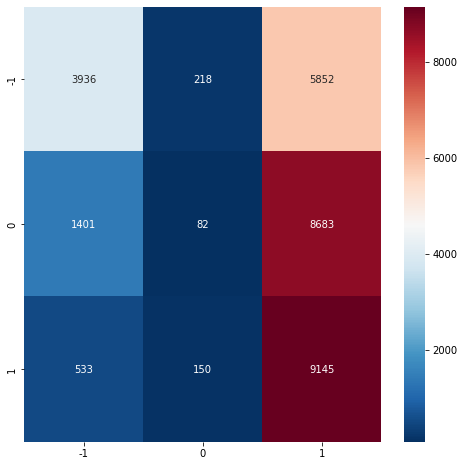

In [16]:
import seaborn as sns
sns.set_context({'figure.figsize':(8,8)})
ax = ['-1','0','1']
sns.heatmap(cm,annot=True,fmt='d',cmap='RdBu_r',xticklabels=ax, yticklabels=ax)



In [17]:
print('accuracy = {}'.format(accuracy_score(y_validation, tb_sent)))
print(classification_report(y_validation, tb_sent))

accuracy = 0.4387666666666667
              precision    recall  f1-score   support

        -1.0       0.67      0.39      0.50     10006
         0.0       0.18      0.01      0.02     10166
         1.0       0.39      0.93      0.55      9828

    accuracy                           0.44     30000
   macro avg       0.41      0.44      0.35     30000
weighted avg       0.41      0.44      0.35     30000



In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


In [19]:
vec = CountVectorizer()
clf = MultinomialNB()


In [20]:
def word_freq(data, max_features):
    count_vec = CountVectorizer(stop_words = 'english', max_feature = max_features)
    count_vec.fit(data.text)
    print('number of unique words:'+ str(len(count_vec.get_feature_names())))

    neg_mat = count_vec.transform(data[data.score < 3].text)
    pos_mat = count_vec.transform(data[data.score > 3].text)
    neu_mat = count_vec.transform(data[data.score == 3].text)
    neg_freq = np.squeeze(np.asarray(np.sum(neg_mat, axis=0)))
    pos_freq = np.squeeze(np.asarray(np.sum(pos_mat, axis=0)))
    neu_freq = np.squeeze(np.asarray(np.sum(neu_mat, axis=0)))

    df_freq = pd.DataFrame([neg_freq, neu_freq, pos_freq], columns=count_vec.get_feature_names()).transpose()
    df_freq.columns = ['neg','neu','pos']
    df_freq['total'] = df_freq['neg'] + df_freq['neu'] + df_freq['pos']
    df_freq = df_freq.sort_values('total', ascending=False)

    return df_freq

In [21]:
# custom_stopwords = list(df_freq.head(25).words)
from time import time
def calc_accuracy(pipeline, X_train, X_test, y_train, y_test):
    t0 = time()
    sentiment_clf = pipeline.fit(X_train, y_train)
    y_pred = sentiment_clf.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    print("model accuracy : {0:.2f}".format(accuracy))
    print("model auc : {0:.2f}".format(roc_auc))
    print("train validation time : {0:.2f}s".format(train_test_time))
    print("=========================================================")
    
    return accuracy, roc_auc, train_test_time

In [22]:
from sklearn.pipeline import Pipeline
n_features = np.arange(10000, 100001,10000)
def compare_clf_nfeature(X_train, X_test, y_train, y_test, vectorizer=vec, clf=clf, n_features=n_features, stop_words=None, ngram_range = (1,1)):
    res = []
    print(clf)
    for feature in n_features:
        vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range, max_features=feature)
        acc_pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', clf)])
        print("result on model with {} features".format(feature))
        accuracy, auc, time = calc_accuracy(acc_pipeline, X_train, X_test, y_train, y_test)
        res.append((feature, accuracy, auc, time))
        
    return res

In [ ]:
results = compare_clf_nfeature(x_train, x_validation, y_train, y_validation)

In [ ]:
results_stop_eng = compare_clf_nfeature(x_train, x_validation, y_train, y_validation, stop_words='english')

In [ ]:
cols = ['n_features', 'val_acc', 'val_auc','time']
results = pd.DataFrame(results,columns=cols)
results_stop_eng = pd.DataFrame(results_stop_eng, columns=cols)


In [ ]:
plt.figure(figsize=(8,4))
plt.plot(results.n_features, results.val_acc, label='without stopwords')
plt.plot(results_stop_eng.n_features, results_stop_eng.val_acc, label='with stopwords')
plt.title('comparison of model performance with and without stopwords')
plt.xlabel('num of features')
plt.ylabel('model validation accuracy')
plt.legend()

In [ ]:
res_bigram = compare_clf_nfeature(x_train, x_validation, y_train, y_validation, ngram_range=(1,2))

In [ ]:
res_trigram = compare_clf_nfeature(x_train, x_validation, y_train, y_validation, ngram_range=(1,3))
res_bigram = pd.DataFrame(res_bigram, columns=cols)
res_trigram = pd.DataFrame(res_trigram, columns=cols)

In [ ]:
clf = MultinomialNB()
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=50000)
x_train = vectorizer.fit_transform(x_train)
x_test, y_test = testset.text, testset.score
# x_test = vectorizer.transform(x_test)

In [ ]:
x_test = vectorizer.transform(x_test)

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
y_pred

In [ ]:
y_pred = clf.predict(x_test)
# y_pred = np.argmax(prob,axis=-1)
# y_pred_prob = [i[1] for i in prob]
nb_accuracy = accuracy_score(y_test, y_pred)
nb_cm = confusion_matrix(y_test, y_pred)

print("accuracy of NB:", nb_accuracy)
print(nb_cm)

In [ ]:
import seaborn as sns
sns.set_context({'figure.figsize':(8,8)})
ax = ['-1','0','1']
sns.heatmap(nb_cm,annot=True,fmt='d',cmap='RdBu_r',xticklabels=ax, yticklabels=ax)

In [ ]:
y_score = clf.predict_proba(x_test)
# y_score = pd.DataFrame(y_score, columns=clf.classes_)
y_score_idx = np.argmax(y_score, axis=-1)
y_prob = [i[2] for i in y_score]



In [ ]:
print(classification_report(y_test, y_pred, digits=4))
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:

def plot_auc(label, prediction):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(label, prediction, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

def find_params(x_train, y_train):
    C_range = np.logspace(-3, 10, 8)
    param_grid = dict(C=C_range)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(LinearSVC(), param_grid=param_grid, cv=cv)
    grid.fit(x_train, y_train)
    
    # Draw plot for gamma-C value result
    score_dict = grid.grid_scores_

    scores = [x[1] for x in score_dict]
    scores = np.array(scores).reshape(len(C_range))
    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.get_cmap("Spectral"))
    plt.ylabel('C')
    plt.colorbar()
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.show()
    
    return grid.best_params_

In [ ]:
def plot_cm(cm):
    sns.set_context({'figure.figsize':(8,8)})
    ax = ['-1','0','1']
    sns.heatmap(cm,annot=True,fmt='d',cmap='RdBu_r',xticklabels=ax, yticklabels=ax)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV


def sentiment_svm(train, test, C, frac = 1, max_features = None, kernel='linear', ngram_range=(1,3), gamma=0, use_params=False):
    X_train, y_train = train.sample(frac=frac, random_state=1234).text, train.sample(frac=frac, random_state=1234).score
    X_test, y_test = test.sample(frac=frac, random_state=1234).text, test.sample(frac=frac, random_state=1234).score 

    tf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train = tf_vectorizer.fit_transform(X_train)
    X_test = tf_vectorizer.transform(X_test)

    #svd = TruncatedSVD(n_components=10)
    #X_train = svd.fit_transform(X_train)
    #X_test = svd.transform(X_test)
    
    if kernel == 'linear':
        if use_params:
            params = find_params(X_train, y_train)
            print ('Best params: %s' % (params))
#             svm = LinearSVC(C=params['C'])
            svm = CalibratedClassifierCV(base_estimator=LinearSVC(C=params['C']), cv=5)
        else:
#             svm = LinearSVC(C=C)
            svm = CalibratedClassifierCV(base_estimator=LinearSVC(C=C), cv=5)
    else:
#         svm = SVC(C=C, gamma=gamma)
        svm = CalibratedClassifierCV(base_estimator=SVC(C=C, gamma=gamma), cv=5)
        
    print(svm)    
    
    t0 = time()
    svm.fit(X_train, y_train)
    train_test_time = time() - t0
    print("training time: {0:.2f}s".format(train_test_time))
    
    probas = svm.predict_proba(X_test)
    y_pred = svm.predict(X_test)
    y_pred_prob = [i[2] for i in probas]

    acc_score = accuracy_score(y_test, y_pred)
    svm_cm = confusion_matrix(y_test, y_pred)
    print("Model accuracy = {0:.3f}%".format(acc_score*100))
    print(classification_report(y_test, y_pred, digits=4))

    plot_auc(y_test, y_pred_prob)
    plot_cm(svm_cm)


In [ ]:
sentiment_svm(trainset, testset, 0.5)

In [ ]:
sentiment_svm(trainset, testset,C=10, frac=0.05,kernel='rbf', gamma=0.1)